## Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import math
from scipy import stats
import xgboost
from xgboost import XGBRegressor
from prophet import Prophet

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor as vIf
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("hour.csv")
df['dteday'] = pd.to_datetime(df['dteday'], errors='coerce')
data = df.copy()
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Preprocessing

In [ ]:
data = data.drop(['instant', 'dteday', 'registered', 'casual'], axis=1)

# The data is stored hourly i.e., at equal intervals, so we ignore the following 4 attributes 
data = data.drop(['yr', 'mnth', 'hr', 'season'], axis=1)

Correlation Matrix :

A correlation matrix is a table of correlation coefficients for a set of variables. Each correlation coefficient in the table represents the strength of the relationship between the two variables.

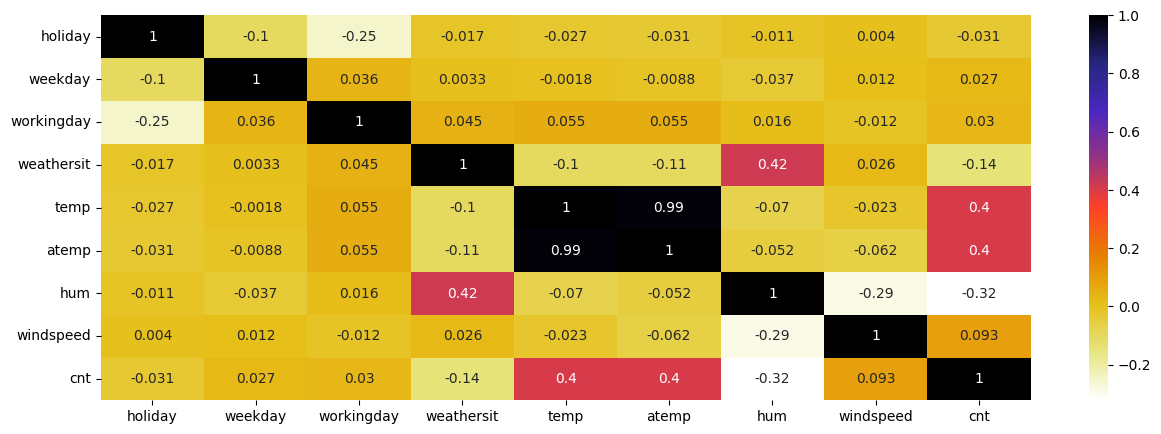

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
dataplot = sns.heatmap(data.corr(), cmap=plt.cm.CMRmap_r, annot=True)

Calculating Variance Inflation Factor (VIF) :

To check for multi-collinearity in the independent variables, we use the Variance Inflation Factor (VIF) technique. The variables with VIF score of > 10 means that they are very strongly correlated. 

In [ ]:
def get_vif(df):
  vif = pd.DataFrame()
  vif["Feature"] = df.columns
  vif["VIF"] = [vIf(df.values, i) for i in range(df.shape[1])]
  print(vif)

get_vif(data)

      Feature         VIF
0     holiday    1.089303
1     weekday    3.029942
2  workingday    3.216224
3  weathersit    7.425854
4        temp  317.281752
5       atemp  347.792032
6         hum   11.606741
7   windspeed    3.105186
8         cnt    2.732247


The attribute *atemp* has the highest VIF, hence we discard it.

In [ ]:
data = data.drop('atemp', axis=1)
get_vif(data)

      Feature        VIF
0     holiday   1.089121
1     weekday   3.024702
2  workingday   3.203988
3  weathersit   7.425207
4        temp   7.909407
5         hum  10.570523
6   windspeed   3.075924
7         cnt   2.700800


The attribute *hum* has the highest VIF, hence we discard it.

In [ ]:
data = data.drop('hum', axis=1)
get_vif(data)

      Feature       VIF
0     holiday  1.079795
1     weekday  2.920970
2  workingday  3.097223
3  weathersit  4.411221
4        temp  6.334978
5   windspeed  3.067688
6         cnt  2.569634


We now see that all the columns have VIF < 10, hence we go ahead with all these attibutes for our analysis.

Feature Scaling

In [ ]:
mm_scaler = MinMaxScaler()

data_t = mm_scaler.fit_transform(data)
data = pd.DataFrame(data_t, columns = list(data.columns))

In [ ]:
data.head()

,holiday,weekday,workingday,weathersit,temp,windspeed,cnt
0,0.0,1.0,0.0,0.0,0.224490,0.0,0.015369
1,0.0,1.0,0.0,0.0,0.204082,0.0,0.039959
2,0.0,1.0,0.0,0.0,0.204082,0.0,0.031762
3,0.0,1.0,0.0,0.0,0.224490,0.0,0.012295
4,0.0,1.0,0.0,0.0,0.224490,0.0,0.000000


In [ ]:
data.describe()

,holiday,weekday,workingday,weathersit,temp,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.028770,0.500614,0.682721,0.141761,0.486722,0.223460,0.193097
std,0.167165,0.334295,0.465431,0.213119,0.196486,0.143811,0.185848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.166667,0.000000,0.000000,0.326531,0.122840,0.039959
50%,0.000000,0.500000,1.000000,0.000000,0.489796,0.228047,0.144467
75%,0.000000,0.833333,1.000000,0.333333,0.653061,0.298225,0.286885
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualization

Predictors :


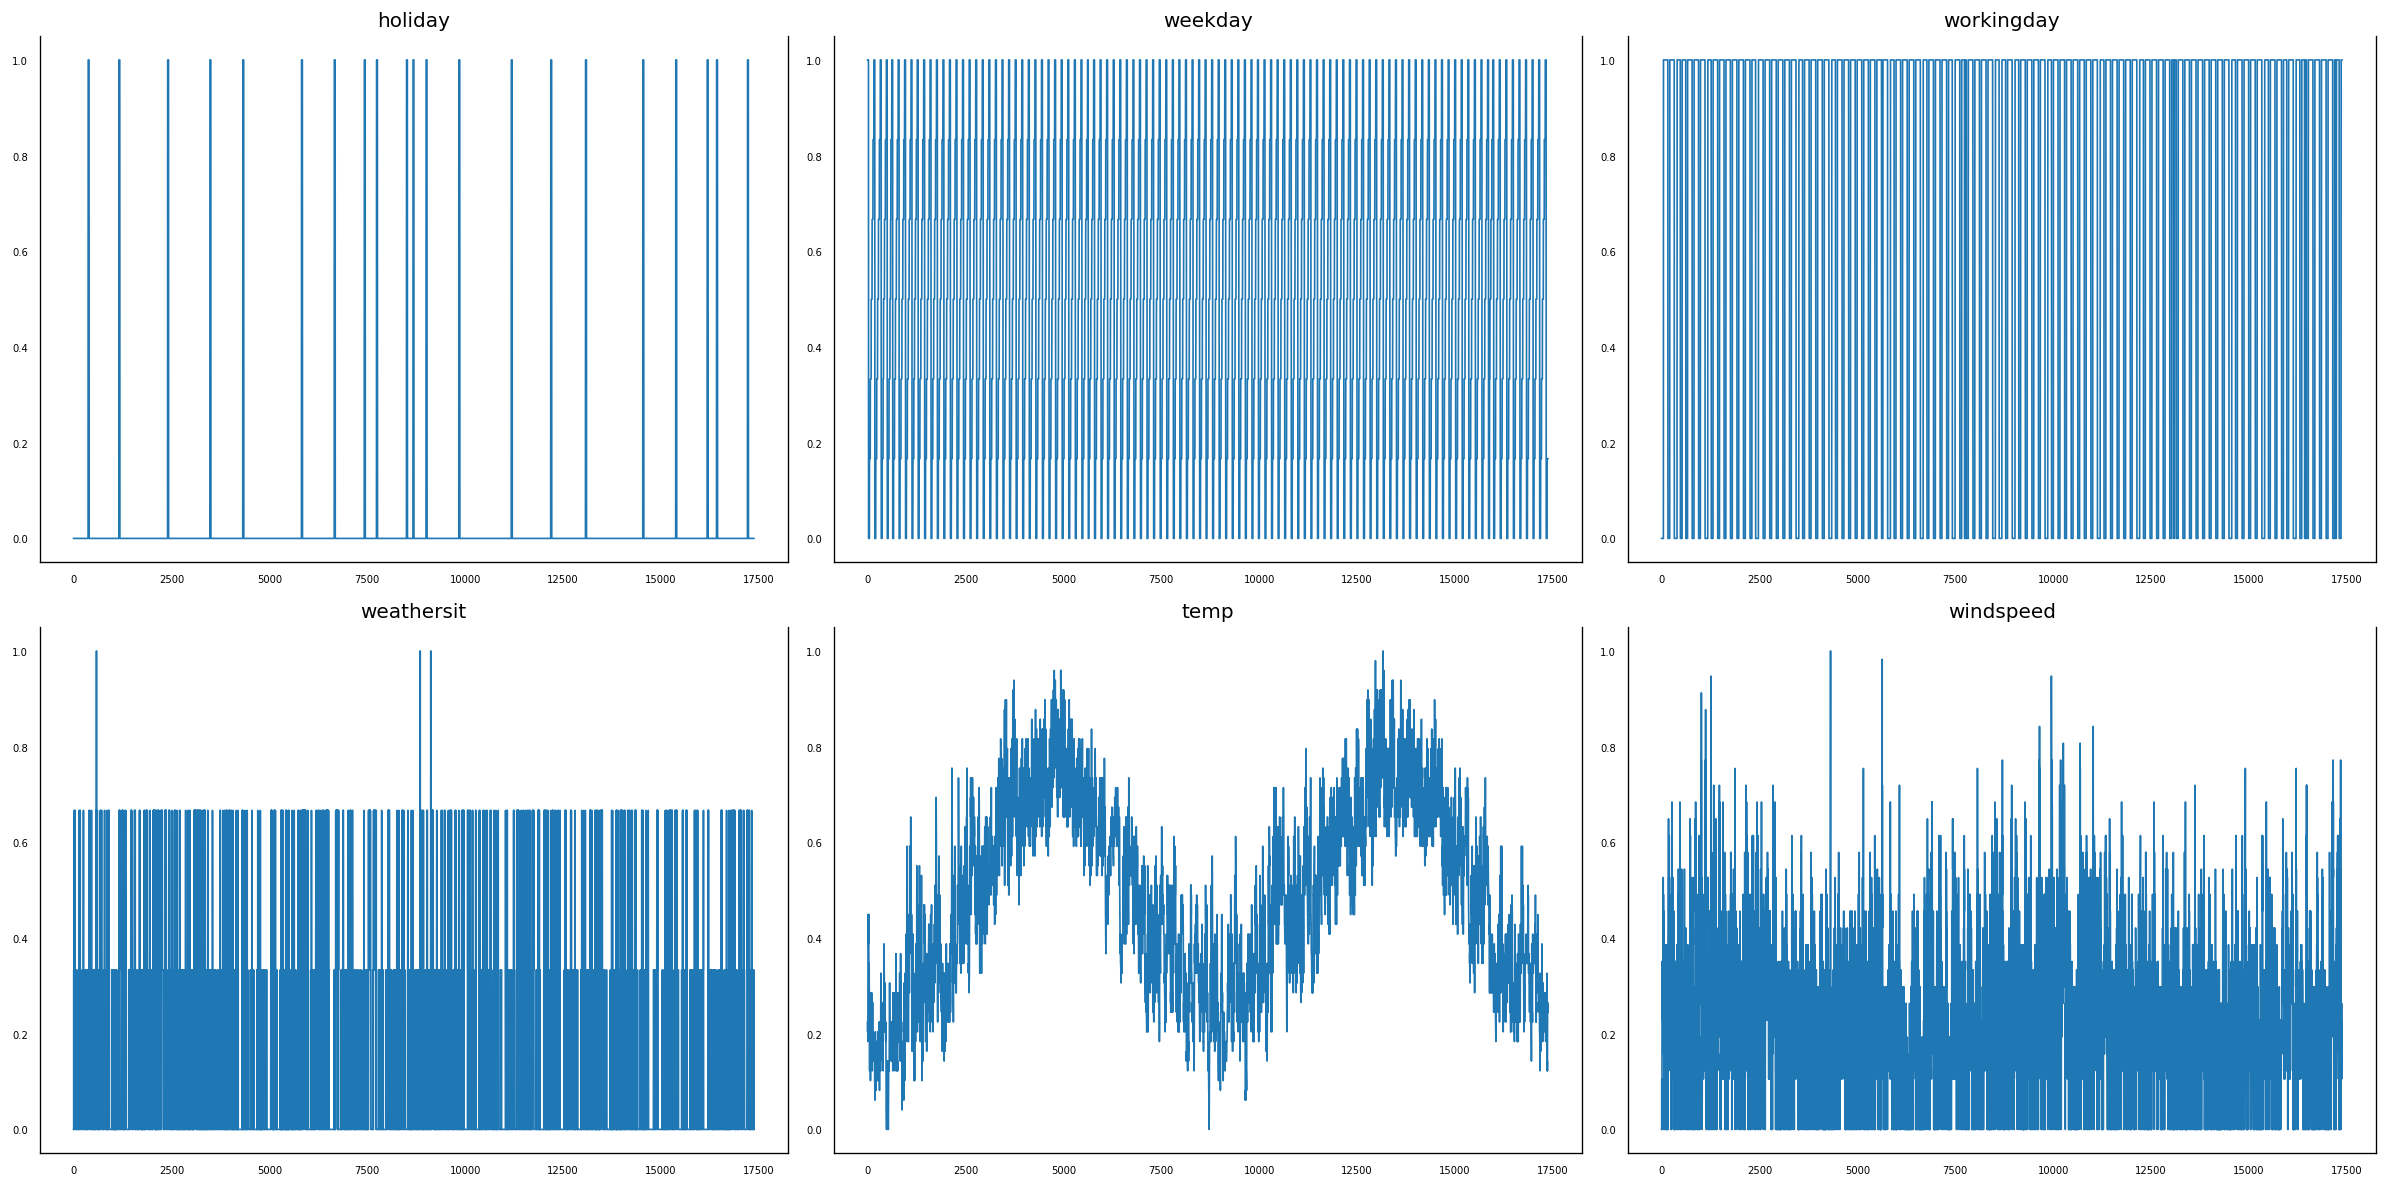

In [ ]:
print("Predictors :")

fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(20,10))
for i, ax in enumerate(axes.flatten()):
    d = data[data.columns[i]]
    ax.plot(d, linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Response Variable 'cnt' (count) :


<Axes: >

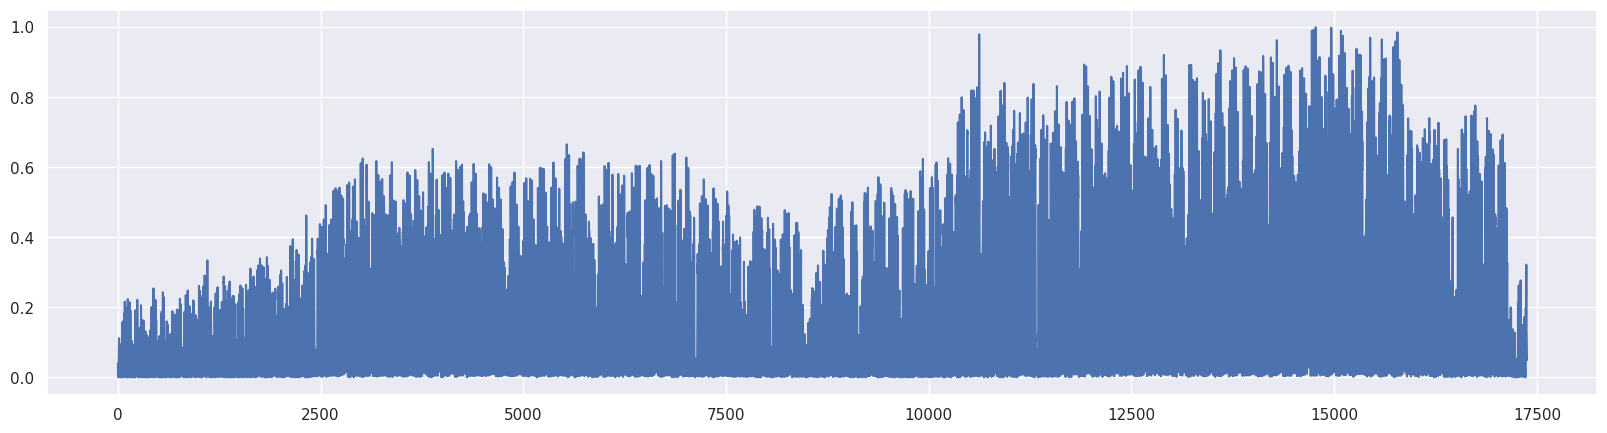

In [ ]:
print("Response Variable 'cnt' (count) :")
data['cnt'].plot(figsize = (20,5))

[Text(0.5, 0, 'Temperature'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Temperature')]

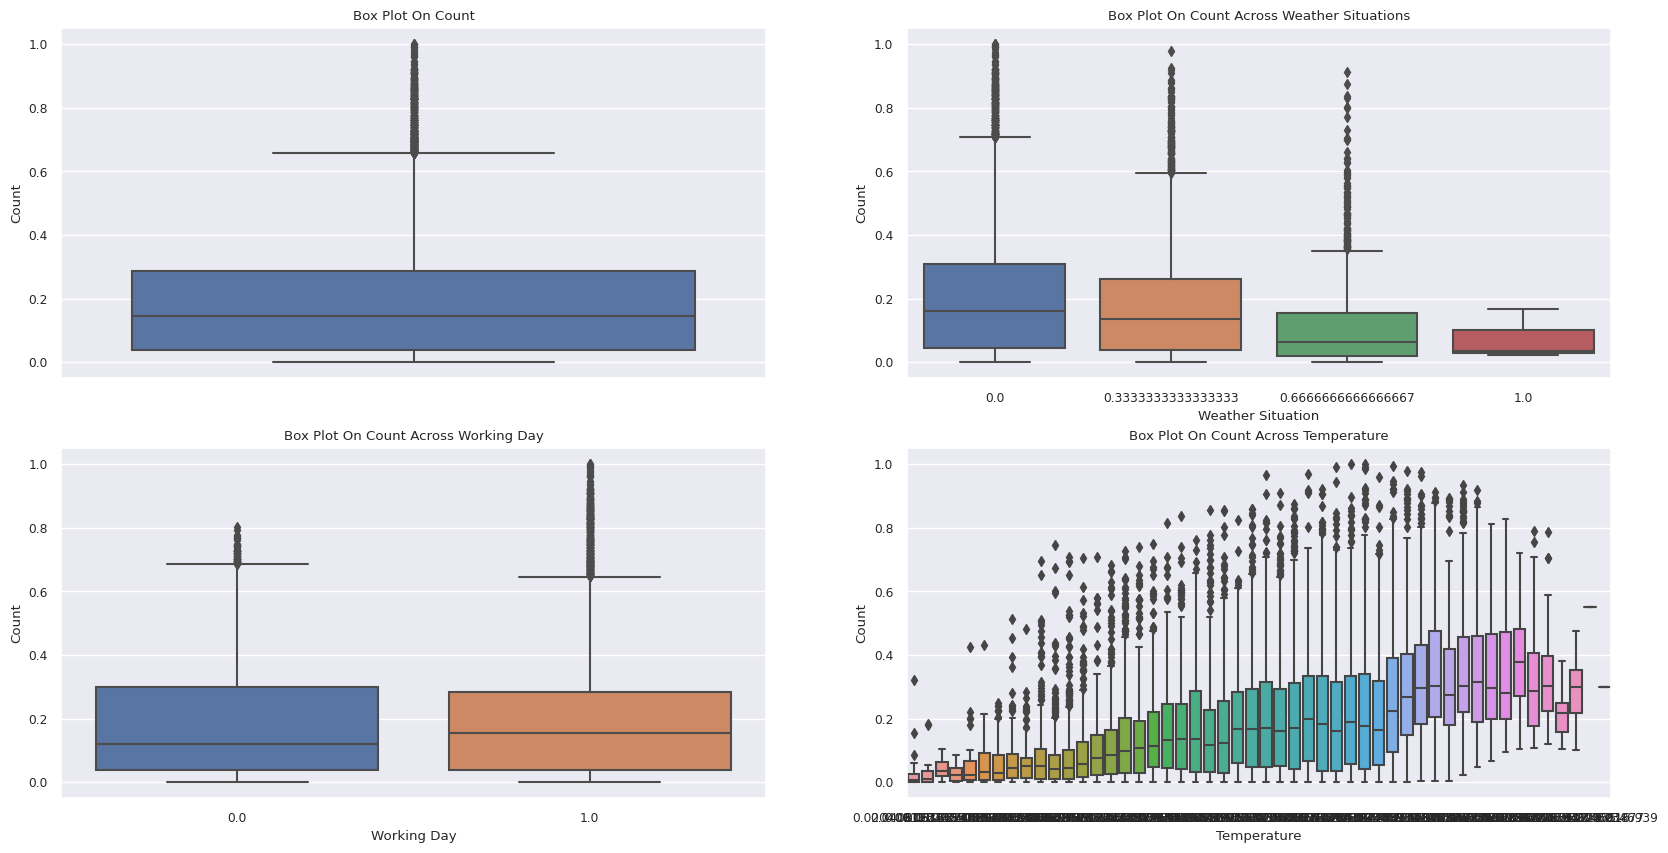

In [ ]:
sns.set(font_scale=0.8)
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sns.boxplot(data=data,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="cnt",x="weathersit",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="cnt",x="workingday",orient="v",ax=axes[1][0])
sns.boxplot(data=data,y="cnt",x="temp",orient="v",ax=axes[1][1])

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")
axes[1][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[1][1].set(xlabel='Temperature', ylabel='Count',title="Box Plot On Count Across Temperature")

## Statistical Normality Test

*   $p <= \alpha$ : reject $H_0$, not normal.
*   $p > \alpha$ : fail to reject $H_0$, normal.

Statistics=3459.832, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 1.4164503546887417
Skewness of normal distribution: 1.2773013463494975


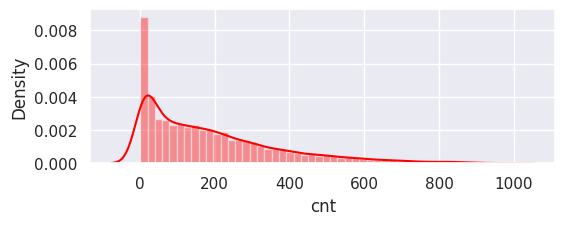

In [ ]:
stat, p = stats.normaltest(df.cnt)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

sns.set(rc={'figure.figsize':(6, 2)})
sns.distplot(df.cnt, color = "red");
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.cnt)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.cnt)))

## Decomposing the Time Series

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series. 

**Additive Model** : <br>
y(t) = Level + Trend + Seasonality + Noise

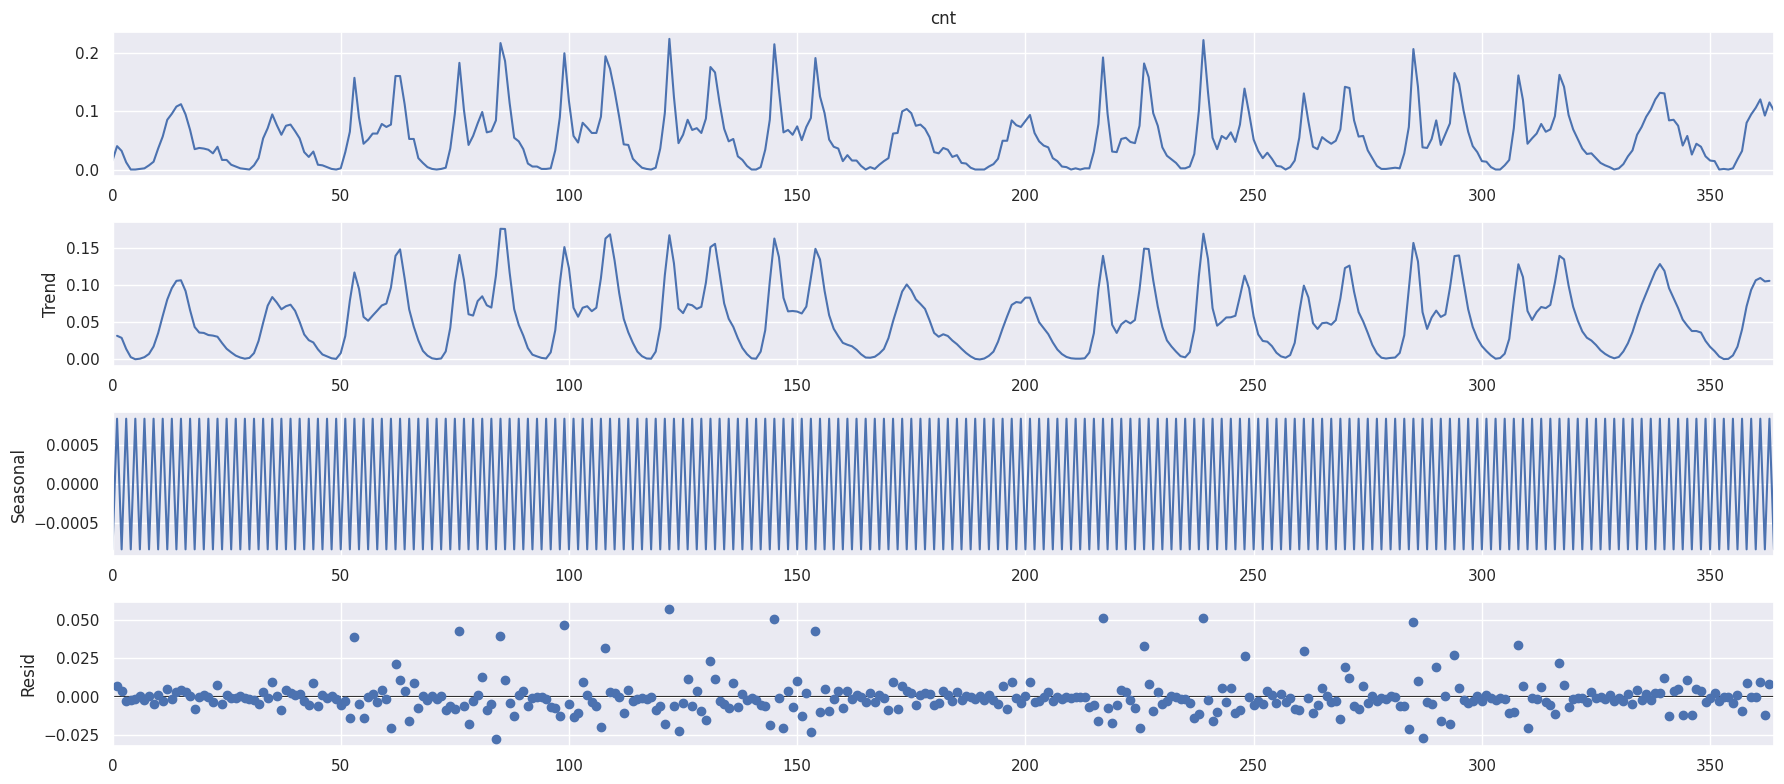

<Figure size 4000x1600 with 0 Axes>

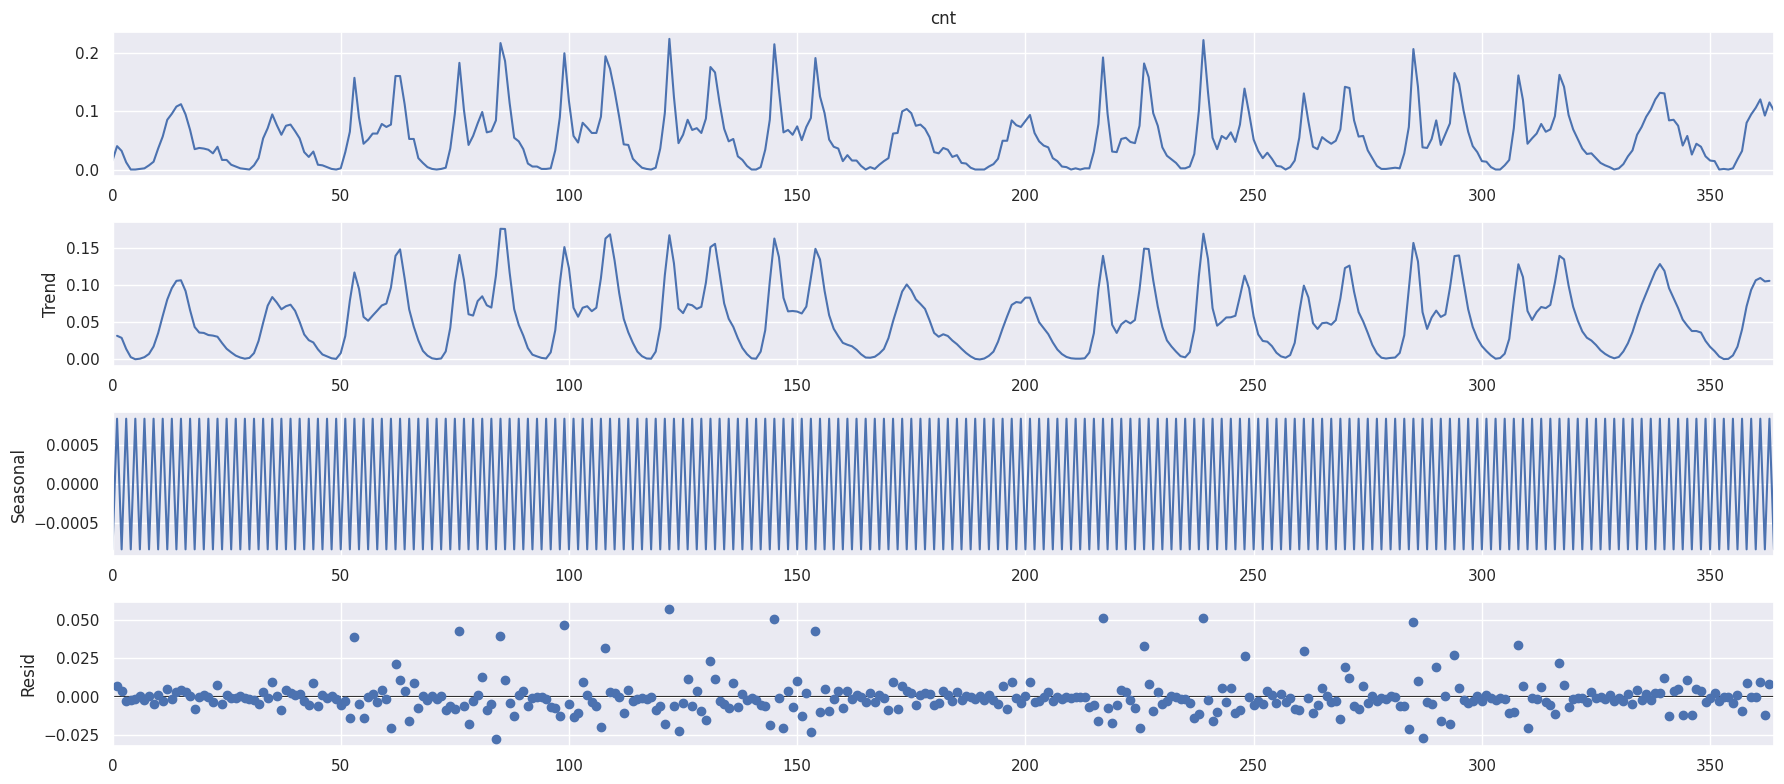

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = data.cnt[:365]
result = seasonal_decompose(series, model = 'additive', period = 2)
result.plot()

## Seasonality

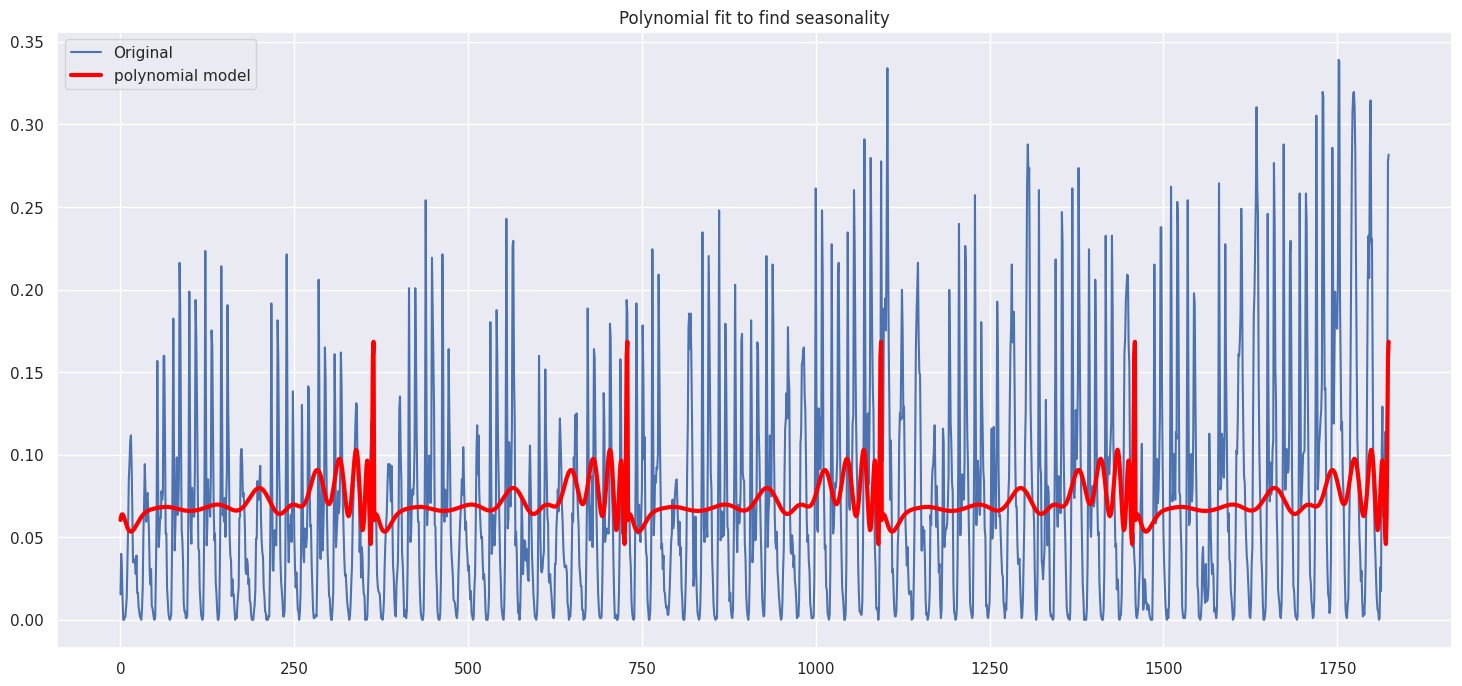

In [ ]:
series = data.cnt.values[:1825] # 5 yrs
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)

# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
    
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

## Noise
Our time series will also have a noise component to them, most likely white noise. We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?

*   Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
*   Correlation plots
*   Standard deviation distribution, is it a Gaussian distribution?
*   Does the mean or level change over time?

Text(0.5, 1.0, 'Mean over time')

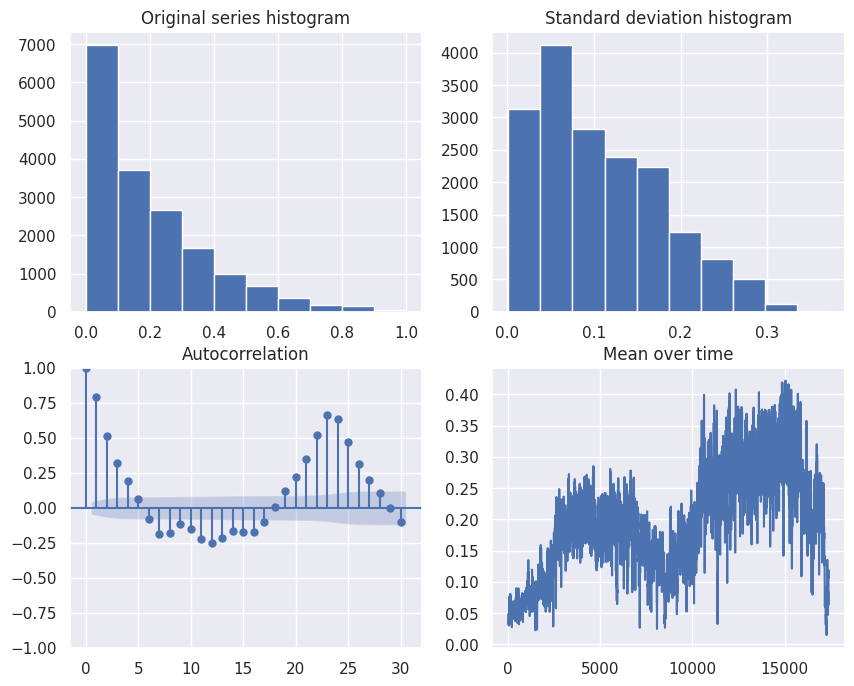

In [ ]:
fig = plt.figure(figsize=(10, 8))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

data.cnt.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = data.cnt.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = data.cnt.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

## Dickey-Fuller Test for Stationarity

* **Null Hypothesis** ($H_0$) : It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure. 

*   **Alternate Hypothesis** ($H_1$) : It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

*   **p-value > 0.05** : Accept the null hypothesis ($H_0$), the data has a unit root and is non-stationary. 

* **p-value <= 0.05** : Reject the null hypothesis ($H_0$), the data does not have a unit root and is stationary.





In [ ]:
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary.")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

for name, column in data.iteritems():
    adfuller_test(column, name=column.name)

 holiday : P-Value = 0.0 => Stationary.
 weekday : P-Value = 0.0 => Stationary.
 workingday : P-Value = 0.0 => Stationary.
 weathersit : P-Value = 0.0 => Stationary.
 temp : P-Value = 0.002 => Stationary.
 windspeed : P-Value = 0.0 => Stationary.
 cnt : P-Value = 0.0 => Stationary.


## Train-Test Split

I split 90% of data as training and 10% as test set.

In [ ]:
training_set_size = int(len(data)*0.9)
test_set_size = len(data)-training_set_size

train_set, test_set = data.iloc[0:training_set_size],data.iloc[training_set_size:len(data)]

print("Length of training set is", len(train_set))    
print("Length of test set is",len(test_set))

Length of training set is 15641
Length of test set is 1738


## Scaling

Since scaling continuous data optimizes model performance, we have scaled temperature and windspeed to have mean 0 and standard deviation 1.

In [ ]:
columns_to_scale = ['temp','windspeed']
temp_wind_transformer = StandardScaler().fit(train_set[columns_to_scale].to_numpy())
cnt_transformer = StandardScaler().fit(train_set[['cnt']])

train_set.loc[:,columns_to_scale] = temp_wind_transformer.transform(train_set[columns_to_scale].to_numpy())
train_set['cnt'] = cnt_transformer.transform(train_set[['cnt']])

test_set.loc[:,columns_to_scale] = temp_wind_transformer.transform(test_set[columns_to_scale].to_numpy())
test_set['cnt'] = cnt_transformer.transform(test_set[['cnt']])

## MODEL 1 : VAR Model

In [ ]:
from statsmodels.tsa.api import VAR

model = VAR(train_set)
for i in range(1, 16):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -25.90571556622999
BIC :  -25.87829709610278
FPE :  5.614236199329191e-12
HQIC:  -25.896637093822175 

Lag Order = 2
AIC :  -26.27192211049488
BIC :  -26.220509621031947
FPE :  3.892684449802674e-12
HQIC:  -26.254898975192564 

Lag Order = 3
AIC :  -26.39570124861061
BIC :  -26.320292071873343
FPE :  3.4394785662298125e-12
HQIC:  -26.370732517333693 

Lag Order = 4
AIC :  -26.441433494030868
BIC :  -26.342024961607244
FPE :  3.2857260643352986e-12
HQIC:  -26.408518233529016 

Lag Order = 5
AIC :  -26.473100804714242
BIC :  -26.34969024771872
FPE :  3.183306282581986e-12
HQIC:  -26.432238081566855 

Lag Order = 6
AIC :  -26.519704737350583
BIC :  -26.372289486423977
FPE :  3.0383556839830614e-12
HQIC:  -26.47089361796674 

Lag Order = 7
AIC :  -26.55730095252359
BIC :  -26.385878337832974
FPE :  2.9262458337144645e-12
HQIC:  -26.50054050314203 

Lag Order = 8
AIC :  -26.668812932920485
BIC :  -26.47338028415906
FPE :  2.6174705413901545e-12
HQIC:  -26.60410221960954

**CONCLUSION** : Since there is no hard-and-fast rule on the choice of the criterion for determining the lag order, we use AIC; i.e., we choose the lag order corresponding to which the AIC is the smallest. Therefore, we will select lag order = 15.

In [ ]:
results = model.fit(maxlags = 15, ic = 'aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Apr, 2023
Time:                     15:05:02
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -26.6834
Nobs:                     15626.0    HQIC:                  -26.9266
Log likelihood:           56853.8    FPE:                1.79326e-12
AIC:                     -27.0470    Det(Omega_mle):     1.71037e-12
--------------------------------------------------------------------
Results for equation holiday
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.010291         0.001241            8.294           0.000
L1.holiday             0.962627         0.008295          116.042           0.000
L1.weekday             0.003095         0.004741      

The biggest correlation is -0.257219 (holiday and workingday).

## Durbin-Watson Test
The DW Test is a measure of autocorrelation in residuals from regression analysis.

The DW statistic ranges from 0.0 to 4.0, with a value of 2.0 indicating zero autocorrelation. Values below 2.0 mean there is positive autocorrelation and above 2.0 indicates negative autocorrelation.

In [ ]:
out = durbin_watson(results.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

holiday : 2.0
weekday : 2.03
workingday : 2.03
weathersit : 2.0
temp : 2.02
windspeed : 2.0
cnt : 2.03


**CONCLUSION** : Since all values are almost equal to 2, this means that there is no autocorrelation detected in the residuals.

## Causality Investigation : Granger Causality Test 

$H_0$ : $Y_t$ does not “Granger cause” $X_{t+1}$, i.e., $𝛼_1 = 𝛼_2 = ⋯ = 𝛼_𝑝 = 0$

$H_A$ : $Y_t$ does “Granger cause” $X_{t+1}$, i.e., at least one of the lags of Y is significant.

In [ ]:
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data, variables = data.columns)

,holiday_x,weekday_x,workingday_x,weathersit_x,temp_x,windspeed_x,cnt_x
holiday_y,1.0000,0.0003,0.0024,0.1052,0.0164,0.3233,0.5112
weekday_y,0.8279,1.0000,0.0000,0.1392,0.3615,0.2215,0.0000
workingday_y,0.0001,0.0000,1.0000,0.0507,0.1180,0.8396,0.0000
weathersit_y,0.1695,0.0826,0.0306,1.0000,0.0006,0.2651,0.0000
temp_y,0.4065,0.1624,0.0497,0.0000,1.0000,0.0000,0.0000
windspeed_y,0.2892,0.3685,0.5187,0.0000,0.0000,0.8648,0.0000
cnt_y,0.0014,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


**NOTE** : The row are the response (Y) and the columns are the predictors (X). <br>
If a given p-value is < significance level (0.05), we can reject the null hypothesis and conclude that x causes y. 

**CONCLUSION** : Observing the last row (i.e., the one corresponding to the attribute 'cnt' as response), we see that all the predictors used cause 'cnt'.

## Forecasting

In [ ]:
lag_order = results.k_ar

df_input = train_set.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps = len(test_set))
df_forecast = (pd.DataFrame(df_forecast, index=test_set.index, columns=test_set.columns + '_pred'))

combined = pd.concat([df_forecast['cnt_pred'], test_set['cnt']], axis=1)
combined.head(10)

,cnt_pred,cnt
15641,0.273882,0.227370
15642,-0.679312,-0.392864
15643,-1.397183,-0.730670
15644,-1.770125,-0.952182
15645,-0.829081,-0.985408
15646,-0.155377,-1.013097
15647,-0.306065,-1.007560
15648,-0.402794,-0.841426
15649,-0.421579,-0.315334
15650,0.178352,-0.187965


### Predicted Count vs Actual count for the first 100 hrs in test set 

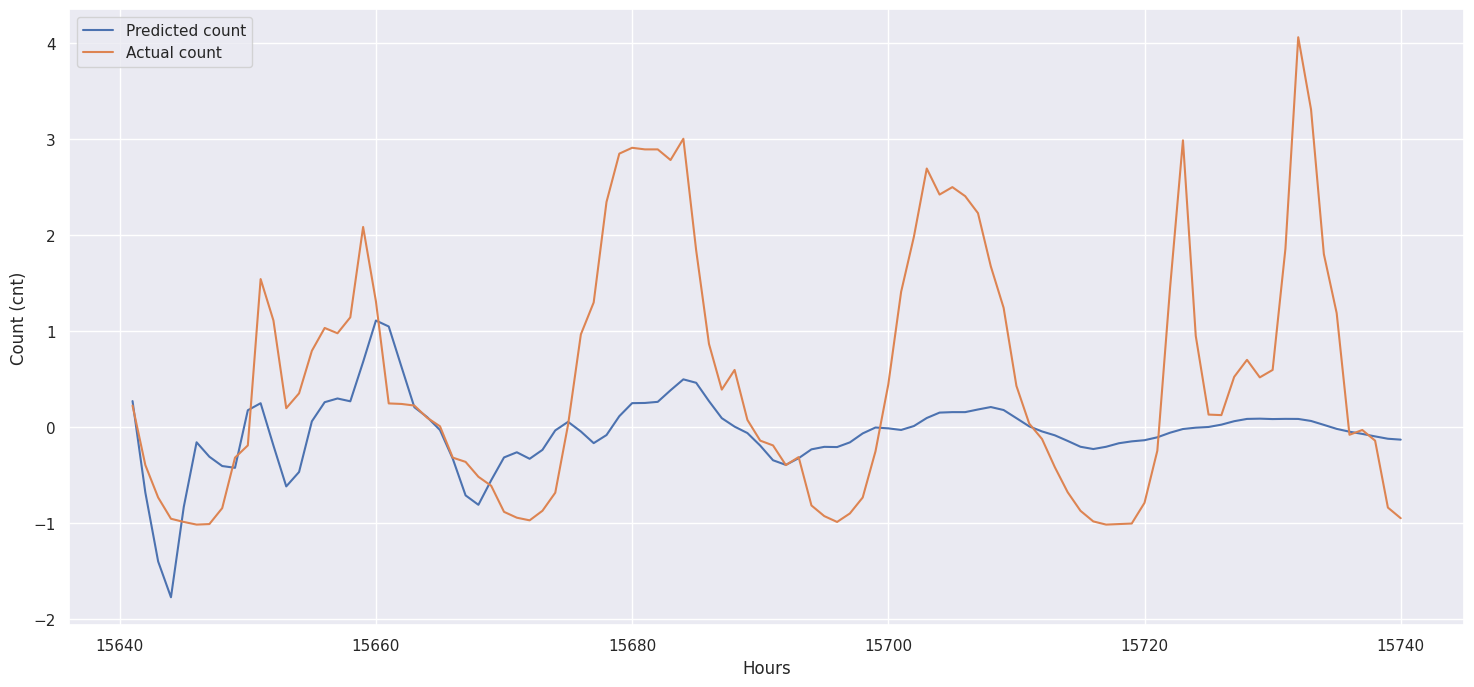

In [ ]:
fig,ax = plt.subplots()
plt.plot(combined["cnt_pred"][:100,], label='Predicted count')
plt.plot(combined["cnt"][:100,], label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

## Accuracy

In [ ]:
RMSE_dict = dict()
rmse = mean_squared_error(combined['cnt_pred'], combined['cnt'], squared = False)
RMSE_dict['VAR'] = rmse

MAE_dict = dict()
mae = mean_absolute_error(combined['cnt_pred'], combined['cnt'])
MAE_dict['VAR'] = mae

print('Forecast accuracy of Count:')
print('RMSE: ', round(rmse, 2))
print('MAE: ', round(mae, 2))

Forecast accuracy of Count:
RMSE:  1.03
MAE:  0.81


## MODEL 2 : Prophet

In [ ]:
mydata = data.copy()
mydata["dteday"] = df["dteday"]
mydata.rename(columns = {'dteday' : 'ds', 'cnt' : 'y'}, inplace = True)

mydata.head(10)

,holiday,weekday,workingday,weathersit,temp,windspeed,y,ds
0,0.0,1.0,0.0,0.000000,-1.405712,-1.56390,0.015369,2011-01-01
1,0.0,1.0,0.0,0.000000,-1.508863,-1.56390,0.039959,2011-01-01
2,0.0,1.0,0.0,0.000000,-1.508863,-1.56390,0.031762,2011-01-01
3,0.0,1.0,0.0,0.000000,-1.405712,-1.56390,0.012295,2011-01-01
4,0.0,1.0,0.0,0.000000,-1.405712,-1.56390,0.000000,2011-01-01
5,0.0,1.0,0.0,0.333333,-1.405712,-0.83039,0.000000,2011-01-01
6,0.0,1.0,0.0,0.000000,-1.508863,-1.56390,0.001025,2011-01-01
7,0.0,1.0,0.0,0.000000,-1.612014,-1.56390,0.002049,2011-01-01
8,0.0,1.0,0.0,0.000000,-1.405712,-1.56390,0.007172,2011-01-01
9,0.0,1.0,0.0,0.000000,-0.993108,-1.56390,0.013320,2011-01-01


In [ ]:
training_set_size = int(len(mydata)*0.9)
test_set_size = len(mydata)-training_set_size

train_set, test_set = mydata.iloc[0:training_set_size], mydata.iloc[training_set_size:len(mydata)]

In [ ]:
model = Prophet()

model.add_regressor('holiday')
model.add_regressor('weekday')
model.add_regressor('workingday')
model.add_regressor('weathersit')
model.add_regressor('temp')
model.add_regressor('windspeed')

model.fit(train_set)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnognm_4p/_biijkjd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnognm_4p/94ha1bv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69773', 'data', 'file=/tmp/tmpnognm_4p/_biijkjd.json', 'init=/tmp/tmpnognm_4p/94ha1bv_.json', 'output', 'file=/tmp/tmpnognm_4p/prophet_model87ds7v37/prophet_model-20230401150628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:06:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast = model.predict(test_set)

d = {'Actual': list(test_set['y']),
    'Predicted': list(forecast['yhat'])}
 
combined = pd.DataFrame(d)
combined.head(10)

,Actual,Predicted
0,0.233607,0.264143
1,0.118852,0.233963
2,0.056352,0.242926
3,0.015369,0.263027
4,0.009221,0.249089
5,0.004098,0.290478
6,0.005123,0.297052
7,0.035861,0.298974
8,0.133197,0.313778
9,0.156762,0.373991


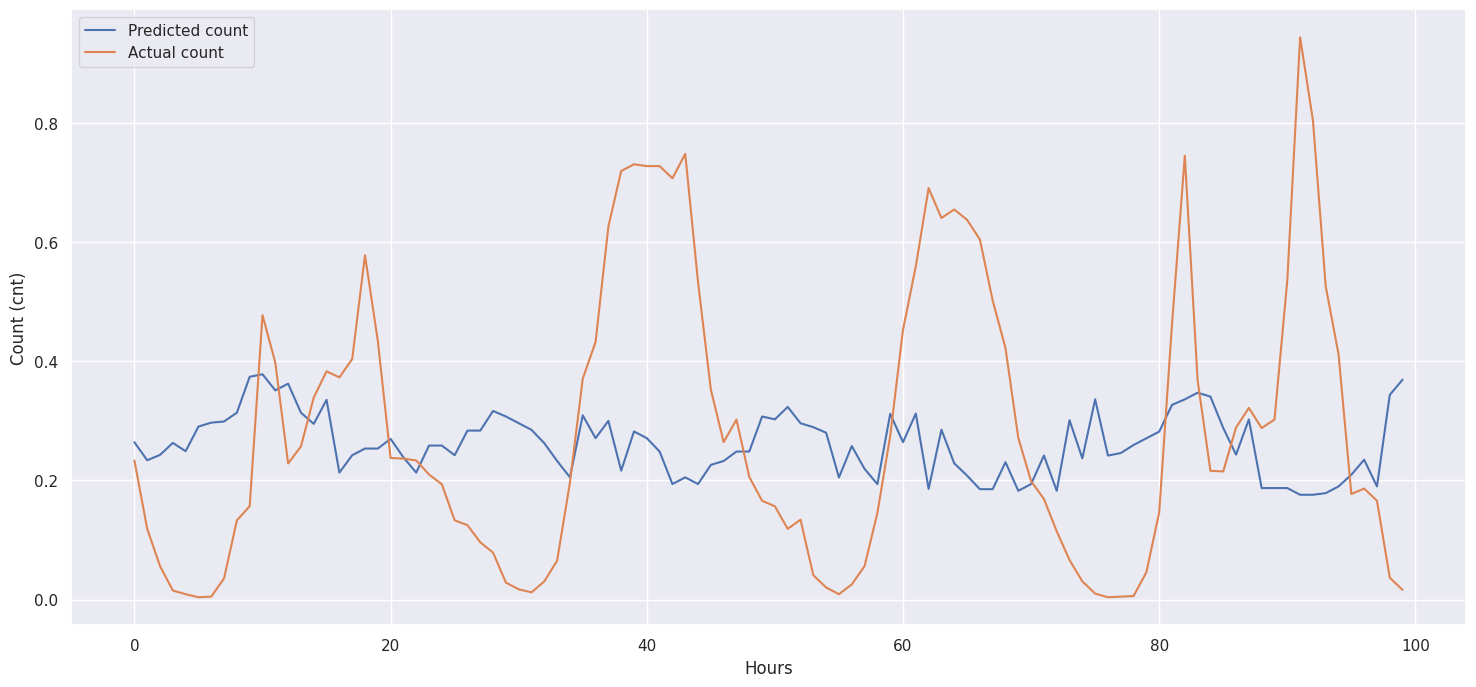

In [ ]:
fig,ax = plt.subplots()
plt.plot(combined["Predicted"][:100,], label='Predicted count')
plt.plot(combined["Actual"][:100,], label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

## Accuracy

In [ ]:
rmse = mean_squared_error(combined['Predicted'], combined['Actual'], squared = False)
RMSE_dict['Prophet'] = rmse

mae = mean_absolute_error(combined['Predicted'], combined['Actual'])
MAE_dict['Prophet'] = mae

print('Forecast accuracy of Count:')
print('RMSE: ', round(rmse, 2))
print('MAE: ', round(mae, 2))

Forecast accuracy of Count:
RMSE:  0.2
MAE:  0.16


## MODEL 3: XGBoost

In [ ]:
X_train = train_set
X_test = test_set

X_train = X_train.drop(['y', 'ds'], axis=1)
X_test = X_test.drop(['y', 'ds'], axis=1)

y_train = train_set.y
y_test = test_set.y

### Train Model

In [ ]:
model = XGBRegressor(objective='count:poisson',n_estimators=300, verbosity=3)xgbmodel = model.fit(X_train, y_train) 
train_forecasts = model.predict(X_train)

[15:07:30] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[15:07:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[15:07:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:07:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:07:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:07:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:07:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:07:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[15:07:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[15:07:30] INFO: ../src/tree/updater

### Test Model

In [ ]:
rmse = mean_squared_error(y_test, test_forecasts, squared = False)
RMSE_dict['XGBoost'] = rmse

mae = mean_absolute_error(y_test, test_forecasts)
MAE_dict['XGBoost'] = mae

print('Forecast accuracy of Count:')
print('RMSE: ', round(rmse, 2))
print('MAE: ', round(mae, 2))

Forecast accuracy of Count:
RMSE:  0.19
MAE:  0.14


### Plot Forecasts Against Targets

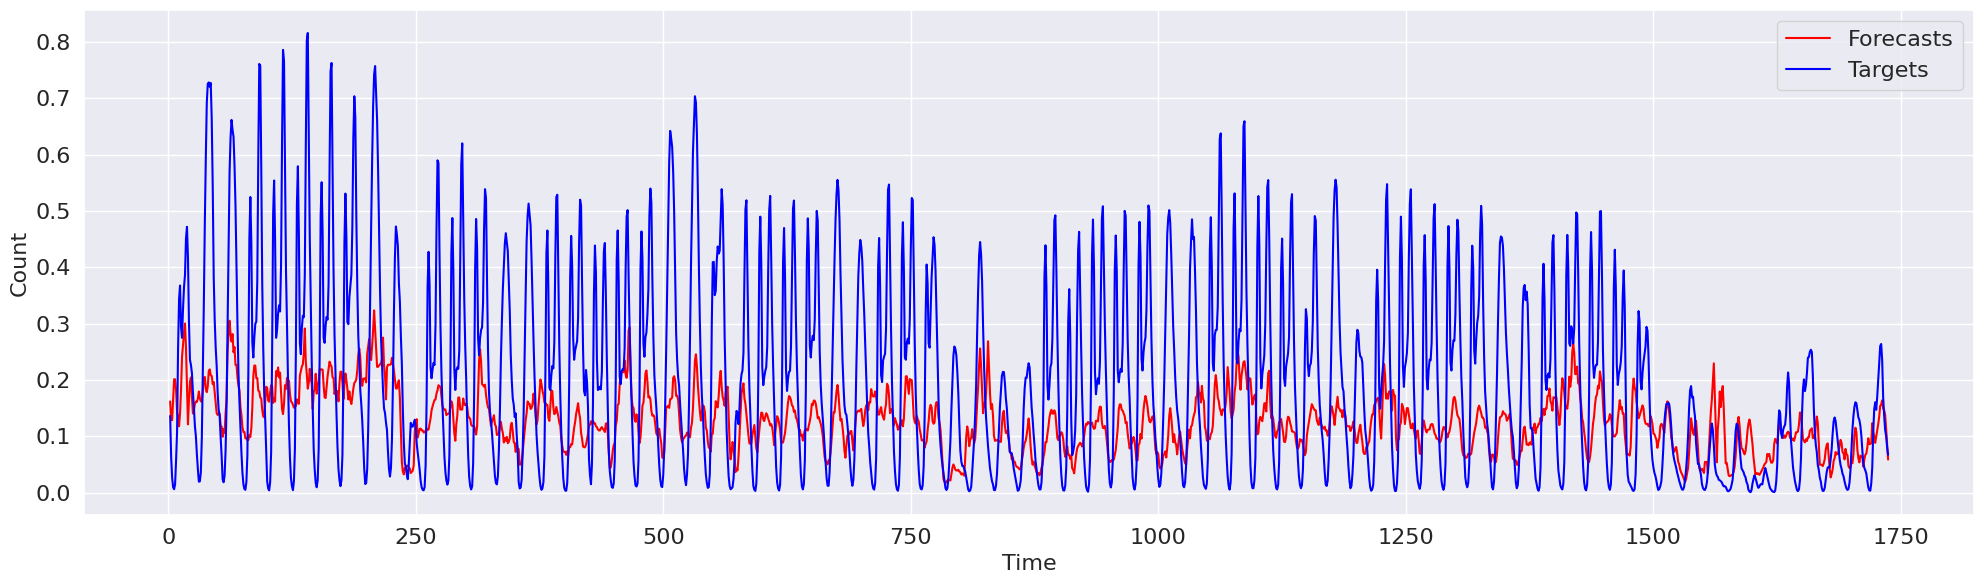

In [ ]:
fontsize = 16
plot_df = pd.DataFrame({"Forecasts" : list(test_forecasts), "Targets" : list(y_test)}, index=range(len(list((y_test)))))

fig = plt.figure(figsize=(20,6))
plt.plot(plot_df.index, plot_df["Forecasts"].rolling(3).mean(), label="Forecasts", color = 'red')
plt.plot(plot_df.index, plot_df["Targets"].rolling(3).mean(), label="Targets", color = 'blue')

plt.xlabel('Time', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Count", fontsize=fontsize)
plt.grid(True)
plt.legend(fontsize=fontsize)
plt.tight_layout()

## MODEL 4 : LSTM

*   The following data pre-processing and feature engineering need to be done before construct the LSTM model.
*   Normalize the features.
*   Split into training and test sets.
*   Convert an array of values into a dataset matrix.
*   Reshape into X=t and Y=t+1.
*   Reshape input to be 3D (num_samples, num_timesteps, num_features)





In [ ]:
dataset = data.cnt.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Model Architecture
 

*   Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Global_active_power. The input shape will be 1 time step with 30 features.

*   Dropout 20%.

*   Use the MSE loss function and the efficient Adam version of stochastic gradient descent.

*   The model will be fit for 20 training epochs with a batch size of 70.

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
199/199 [==============================] - 4s 8ms/step - loss: 0.0060 - val_loss: 0.0072
Epoch 2/20
199/199 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0062
Epoch 3/20
199/199 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 4/20
199/199 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0053
Epoch 5/20
199/199 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 6/20
199/199 [==============================] - 1s 5ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 7/20
199/199 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 8/20
199/199 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 9/20
199/199 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 10/20
199/199 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0043

## Make Predictions

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

rmse = mean_squared_error(Y_test[0], test_predict[:,0], squared = False)
RMSE_dict['LSTM'] = rmse

mae = mean_absolute_error(Y_test[0], test_predict[:,0])
MAE_dict['LSTM'] = mae

print('Forecast accuracy of Count:')
print('RMSE: ', round(rmse, 2))
print('MAE: ', round(mae, 2))

108/108 [==============================] - 0s 2ms/step
Forecast accuracy of Count:
RMSE:  0.06
MAE:  0.04


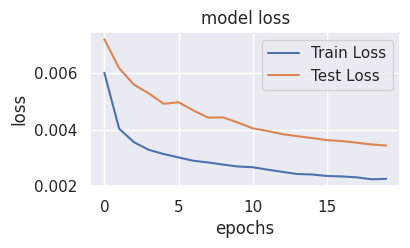

In [ ]:
# Plot of Model Loss
plt.figure(figsize=(4, 2))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

## Compare Actual vs. Prediction

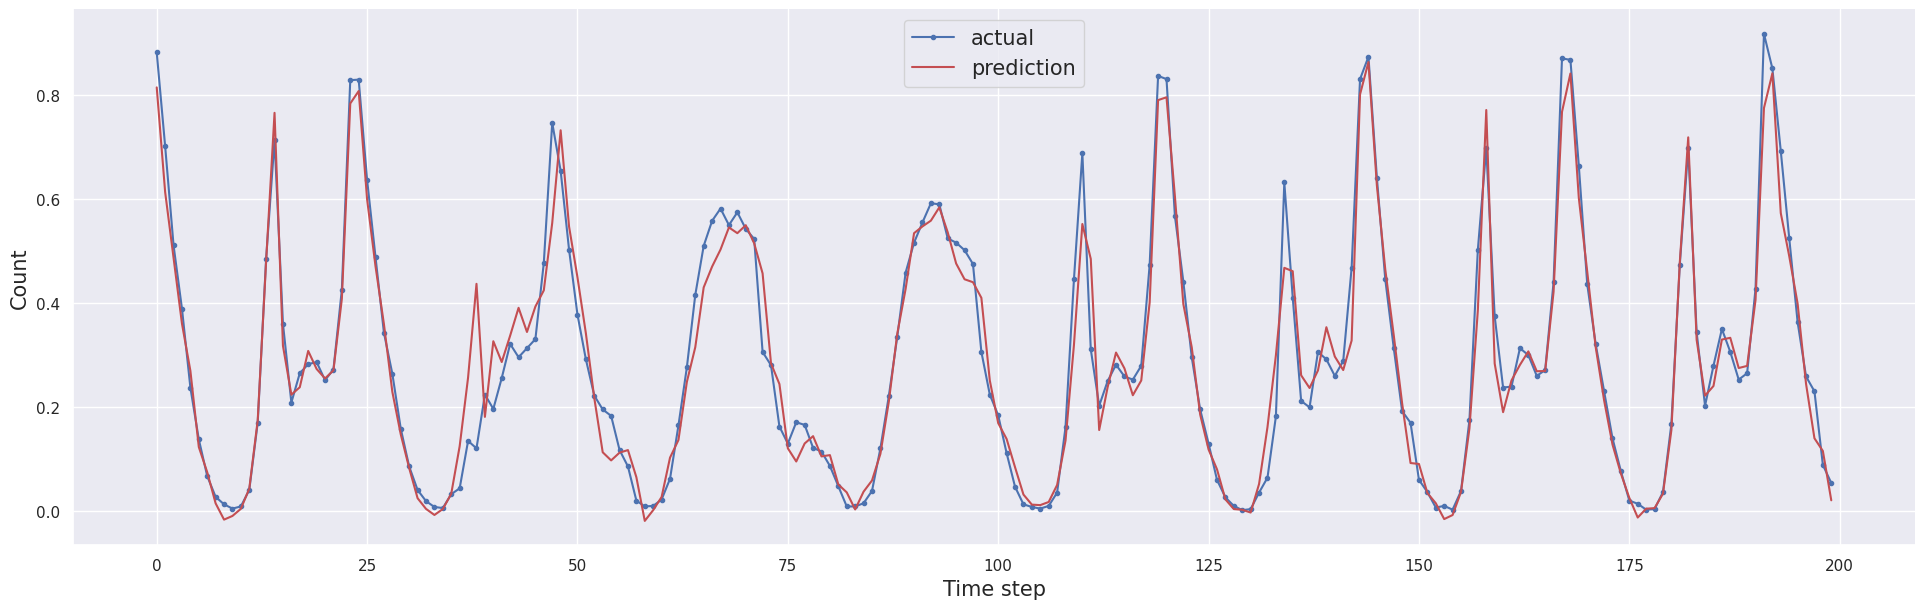

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(20,6))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Count', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## Comparison of Performance of the 4 models

In [ ]:
for key in RMSE_dict.keys():
    RMSE_dict[key] = [RMSE_dict[key]]

performance = pd.DataFrame(RMSE_dict)
performance.loc[len(performance.index)] = MAE_dict.values()
performance.index = ['RMSE', 'MAE']

display(performance)

,VAR,Prophet,XGBoost,LSTM
RMSE,1.034521,0.199104,0.194832,0.058633
MAE,0.809159,0.157682,0.136887,0.040403


**CONCLUSION** : We see from the above table that every model performs better than the previous one, *LSTM* being the best.